In [1]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.7 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16425 sha256=624a068bf177eec8825da6b23ab2f6eb48fefcf7953bcf49dcb99aea337ebf2c
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=aa876e0bdf67012970e49f4d13bb67b6494e1c95d4afe25b244e88d5b10e31a4
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

In [2]:
!wget http://images.cocodataset.org/zips/val2017.zip

--2024-10-12 07:45:00--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.174.169, 52.217.199.153, 52.217.82.236, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.174.169|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  53.7MB/s    in 15s     

2024-10-12 07:45:15 (51.5 MB/s) - ‘val2017.zip’ saved [815585330/815585330]



In [3]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2024-10-12 07:45:15--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.28.47, 52.216.29.236, 52.217.98.132, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.28.47|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  51.6MB/s    in 5.1s    

2024-10-12 07:45:20 (46.8 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]



In [4]:
!unzip val2017.zip

Streaming output truncated to the last 5000 lines.
 extracting: val2017/000000212226.jpg  
 extracting: val2017/000000231527.jpg  
 extracting: val2017/000000578922.jpg  
 extracting: val2017/000000062808.jpg  
 extracting: val2017/000000119038.jpg  
 extracting: val2017/000000114871.jpg  
 extracting: val2017/000000463918.jpg  
 extracting: val2017/000000365745.jpg  
 extracting: val2017/000000320425.jpg  
 extracting: val2017/000000481404.jpg  
 extracting: val2017/000000314294.jpg  
 extracting: val2017/000000335328.jpg  
 extracting: val2017/000000513688.jpg  
 extracting: val2017/000000158548.jpg  
 extracting: val2017/000000132116.jpg  
 extracting: val2017/000000415238.jpg  
 extracting: val2017/000000321333.jpg  
 extracting: val2017/000000081738.jpg  
 extracting: val2017/000000577584.jpg  
 extracting: val2017/000000346905.jpg  
 extracting: val2017/000000433980.jpg  
 extracting: val2017/000000228144.jpg  
 extracting: val2017/000000041872.jpg  
 extracting: val2017/00000011

In [5]:
!unzip annotations_trainval2017.zip

Archive:  annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


In [6]:
import os
len(os.listdir("val2017"))

5000

In [7]:
import os
import json
import numpy as np
import torch
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from pycocotools import mask as mask_utils

### Load the Dataset

In [8]:
class COCOSegmentationDataset(Dataset):
  def __init__(self,images_dir,annotation_file,transform_image=None, transform_mask=None):
    self.coco = COCO(annotation_file)
    self.images_dir=images_dir
    self.transform_image = transform_image
    self.transform_mask = transform_mask
    self.image_ids = self.coco.getImgIds()
    self.class_ids = sorted(self.coco.getCatIds())

  def __len__(self):
    return len(self.image_ids)

  def __getitem__(self,idx):
    img_id=self.image_ids[idx]
    img_info = self.coco.imgs[img_id]
    image=Image.open(os.path.join(self.images_dir,img_info['file_name'])).convert('RGB')
    mask=np.zeros((img_info['height'], img_info['width']),dtype=np.uint8)
    ann_ids = self.coco.getAnnIds(imgIds=img_id)
    for ann_id in ann_ids:
      annotation=self.coco.anns[ann_id]
      category_id=annotation['category_id']
      segmentation=annotation['segmentation']
      if isinstance(segmentation, list):
          rle = mask_utils.frPyObjects(segmentation, img_info['height'], img_info['width'])
          rle = mask_utils.merge(rle)
          binary_mask = mask_utils.decode(rle)
          mask[binary_mask > 0] = category_id
    mask_pil = Image.fromarray(mask)
    if self.transform_image:
      image = self.transform_image(image)
    if self.transform_mask:
      mask = self.transform_mask(mask_pil)

    return image, mask

### Transforms and DataLoaders

In [9]:
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
mask_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

images_dir = 'val2017'
annotations_file = 'annotations/instances_val2017.json'


val_dataset = COCOSegmentationDataset(images_dir, annotations_file, transform_image=image_transforms,  transform_mask=mask_transforms )
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

loading annotations into memory...
Done (t=1.21s)
creating index...
index created!


### LOAD a Pre-trained model

In [10]:
import torchvision.models.segmentation as segmentation

In [11]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
model = segmentation.deeplabv3_resnet101(pretrained=True)
model.classifier[4] = torch.nn.Conv2d(256, len(val_dataset.class_ids), kernel_size=(1, 1))
model = model.to(device)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:02<00:00, 93.4MB/s]


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

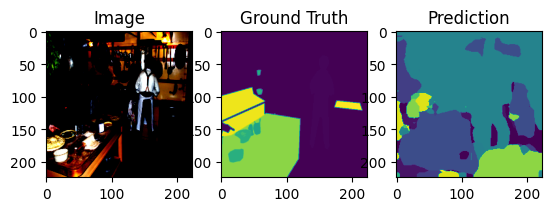

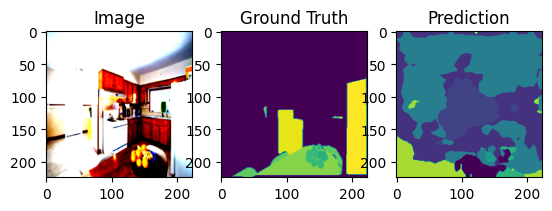

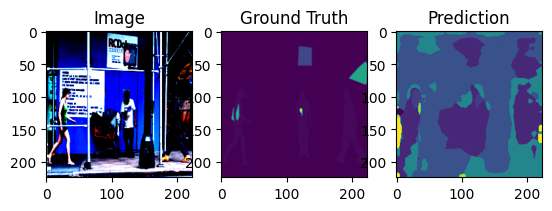

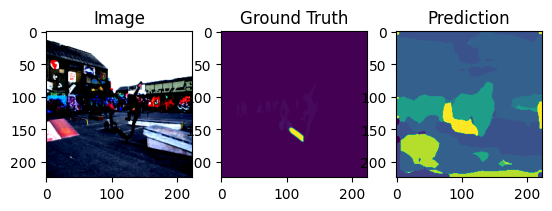

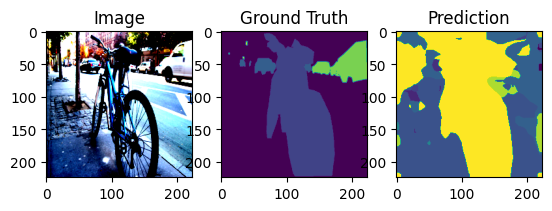

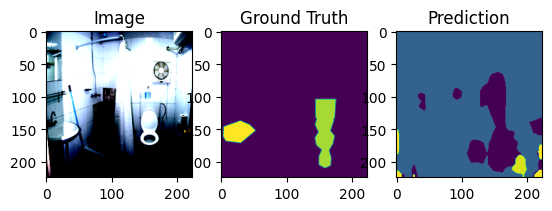

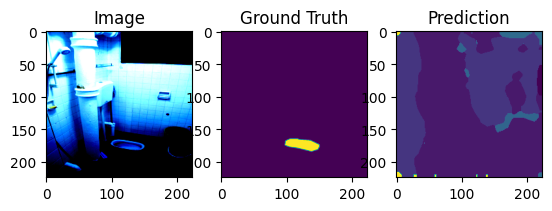

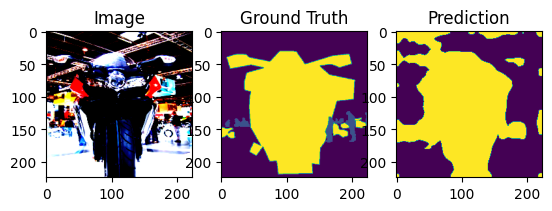

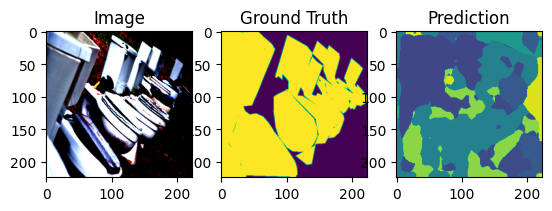

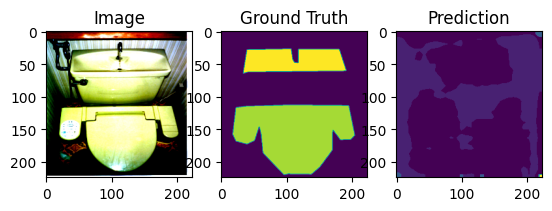

In [13]:

with torch.no_grad():
    for idx,(images, masks) in enumerate(val_loader):
      if idx==5:
        break
      images = images.to(device)
      outputs = model(images)['out']
      predictions = outputs.argmax(dim=1).cpu().numpy()

      for i in range(len(images)):
          plt.subplot(1, 3, 1)
          plt.imshow(images[i].cpu().numpy().transpose(1, 2, 0))
          plt.title('Image')

          plt.subplot(1, 3, 2)
          plt.imshow(masks[i].squeeze().cpu().numpy())
          plt.title('Ground Truth')

          plt.subplot(1, 3, 3)
          plt.imshow(predictions[i])
          plt.title('Prediction')

          plt.show()


## Training

In [64]:
import os
import json
import random


val_images_dir = 'val2017'
annotation_file = 'annotations/instances_val2017.json'


with open(annotation_file) as f:
    coco_annotations = json.load(f)


image_ids = [img['id'] for img in coco_annotations['images']]
random.shuffle(image_ids)
split_idx = int(0.8 * len(image_ids))
train_image_ids = set(image_ids[:split_idx])
val_image_ids = set(image_ids[split_idx:])


def split_annotations(annotations, image_ids_set):
    return [ann for ann in annotations if ann['image_id'] in image_ids_set]

train_annotations = split_annotations(coco_annotations['annotations'], train_image_ids)
val_annotations = split_annotations(coco_annotations['annotations'], val_image_ids)


train_annotations_file = 'train_annotations.json'
val_annotations_file = 'val_annotations.json'

with open(train_annotations_file, 'w') as f:
    json.dump({
        'info': coco_annotations['info'],
        'licenses': coco_annotations['licenses'],
        'images': [img for img in coco_annotations['images'] if img['id'] in train_image_ids],
        'annotations': train_annotations,
        'categories': coco_annotations['categories']
    }, f)

with open(val_annotations_file, 'w') as f:
    json.dump({
        'info': coco_annotations['info'],
        'licenses': coco_annotations['licenses'],
        'images': [img for img in coco_annotations['images'] if img['id'] in val_image_ids],
        'annotations': val_annotations,
        'categories': coco_annotations['categories']
    }, f)


In [65]:
import os
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from pycocotools.coco import COCO
from torch.utils.data import Dataset

class COCOSegmentationDataset(Dataset):
    def __init__(self, image_dir, annotation_file, transform_image=None, transform_mask=None):
        self.image_dir = image_dir
        self.coco = COCO(annotation_file)
        self.image_ids = list(self.coco.imgs.keys())
        self.transform_image = transform_image
        self.transform_mask = transform_mask
        self.id_to_name = {}
        self.name_to_id = {}

        categories = self.coco.loadCats(self.coco.getCatIds())
        for cat in categories:

            self.name_to_id[cat['name']] = cat['id']

        self.name_to_id["background"] = 0

        self.class_size =  max(self.name_to_id.values()) + 1  # +1 if you want to include the background (ID 0)

        print(self.class_size)
        print(f"name_to_id: {self.name_to_id}")


    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.coco.imgs[image_id]
        image_path = os.path.join(self.image_dir, image_info['file_name'])
        image = Image.open(image_path).convert("RGB")
        mask = np.zeros((image_info['height'], image_info['width']), dtype=np.uint8)
        annotations = self.coco.loadAnns(self.coco.getAnnIds(imgIds=image_id))
        for ann in annotations:
            if 'segmentation' in ann:
                rle = ann['segmentation']
                category_id = ann['category_id']
                category_name = self.coco.loadCats(category_id)[0]['name']

                binary_mask = self.coco.annToMask(ann)
                if category_id in self.coco.getCatIds():
                  mask[binary_mask > 0] = category_id

        mask = Image.fromarray(mask)
        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)
        mask = torch.from_numpy(np.array(mask)).long()
        mask = mask.unsqueeze(0)

        # print(f'Image shape: {image.size()}, Mask shape: {mask.size()}')

        return image, mask


In [66]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((224, 224),interpolation=Image.NEAREST),


])

In [67]:

train_dataset = COCOSegmentationDataset(val_images_dir, train_annotations_file, transform_image=image_transform, transform_mask=mask_transform)
val_dataset = COCOSegmentationDataset(val_images_dir, val_annotations_file, transform_image=image_transform, transform_mask=mask_transform)


loading annotations into memory...
Done (t=1.28s)
creating index...
index created!
91
name_to_id: {'person': 1, 'bicycle': 2, 'car': 3, 'motorcycle': 4, 'airplane': 5, 'bus': 6, 'train': 7, 'truck': 8, 'boat': 9, 'traffic light': 10, 'fire hydrant': 11, 'stop sign': 13, 'parking meter': 14, 'bench': 15, 'bird': 16, 'cat': 17, 'dog': 18, 'horse': 19, 'sheep': 20, 'cow': 21, 'elephant': 22, 'bear': 23, 'zebra': 24, 'giraffe': 25, 'backpack': 27, 'umbrella': 28, 'handbag': 31, 'tie': 32, 'suitcase': 33, 'frisbee': 34, 'skis': 35, 'snowboard': 36, 'sports ball': 37, 'kite': 38, 'baseball bat': 39, 'baseball glove': 40, 'skateboard': 41, 'surfboard': 42, 'tennis racket': 43, 'bottle': 44, 'wine glass': 46, 'cup': 47, 'fork': 48, 'knife': 49, 'spoon': 50, 'bowl': 51, 'banana': 52, 'apple': 53, 'sandwich': 54, 'orange': 55, 'broccoli': 56, 'carrot': 57, 'hot dog': 58, 'pizza': 59, 'donut': 60, 'cake': 61, 'chair': 62, 'couch': 63, 'potted plant': 64, 'bed': 65, 'dining table': 67, 'toilet': 7

In [68]:
def custom_collate_fn(batch):
    images, masks = zip(*batch)
    images = torch.stack(images, dim=0)
    masks = [mask.unsqueeze(0) for mask in masks]
    return images, masks

In [69]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

In [70]:
import segmentation_models_pytorch as smp

In [71]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim import lr_scheduler


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_size= train_dataset.class_size

model=smp.Unet(encoder_name="efficientnet-b4",
               encoder_weights="imagenet",
               in_channels=3,
               classes=class_size,
               )



In [74]:
def train(dataloader, model, loss_fn, optimizer, lr_scheduler, device):
    class_size=train_dataset.class_size
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    epoch_loss = 0
    epoch_iou_score = 0
    for batch_i, (x, y) in enumerate(dataloader):

        x, y = x.to(device), y.to(device).squeeze()
        unique_values = torch.unique(y)

        pred = model(x)

        optimizer.zero_grad()

        if torch.max(y) >= class_size:
            raise ValueError(f"Target mask contains class index {torch.max(y).item()} which exceeds the number of classes {class_size - 1}.")
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        pred = torch.argmax(pred, dim=1)

        print(f'Predictions unique values: {torch.unique(pred)}')
        tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode="multiclass", num_classes=class_size)
        iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
        epoch_iou_score += iou_score
    lr_scheduler.step()
    return epoch_loss / num_batches, epoch_iou_score / num_batches


def test(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    epoch_loss = 0
    epoch_iou_score = 0
    class_size=train_dataset.class_size
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(dataloader):

            x, y = x.to(device), y.to(device).squeeze()

            pred = model(x)

            loss = loss_fn(pred, y)
            epoch_loss += loss.item()

            pred = torch.argmax(pred, dim=1)

            print(f'Predictions unique values: {torch.unique(pred)}')
            tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode="multiclass", num_classes=class_size)
            iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
            epoch_iou_score += iou_score
    return epoch_loss / num_batches, epoch_iou_score / num_batches


In [75]:
from torch import nn
device=torch.device('cuda' if torch.cuda.is_available() else "cpu")

EPOCHS=30
logs={
    'train_loss':[],'val_loss':[],
    'train_iou_score':[],'val_iou_score':[],
}
if not os.path.exists('/content/checkpoints'):
  os.makedirs("/content/checkpoints")

num_classes=train_dataset.class_size
class_counts = [0] * train_dataset.class_size

for images, masks in train_loader:
    for mask in masks:
        unique_values, counts = torch.unique(mask, return_counts=True)
        for value, count in zip(unique_values, counts):
            class_counts[value.item()] += count.item()


class_weights = torch.tensor([1.0 / (count + 1) for count in class_counts], device=device)

loss_fn = nn.CrossEntropyLoss(weight=class_weights)


learning_rate=0.0001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)
patience=3
counter=0
best_loss=np.inf

model.to(device)
for epoch in tqdm(range(EPOCHS)):
  train_loss,train_iou_score=train(train_loader,model,loss_fn,optimizer,step_lr_scheduler,device)
  val_loss,val_iou_score=test(val_loader,model,loss_fn,device)
  logs['train_loss'].append(train_loss)
  logs['val_loss'].append(val_loss)
  logs['train_iou_score'].append(train_iou_score)
  logs['val_iou_score'].append(val_iou_score)

  print(f'EPOCH: {str(epoch+1).zfill(3)} \
  train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f} \
  train_iou_score: {train_iou_score:.3f}, val_iou_score: {val_iou_score:.3f} \
  lr: {optimizer.param_groups[0]["lr"]}')
  torch.save(model.state_dict(),"/content/checkpoints/last.pth")

  if val_loss<best_loss:
    counter=0

    best_loss=val_loss
    torch.save(model.state_dict(),"/content/checkpoints/best.pth")
  else:
    counter+=1

  if counter>=patience:
    print("Early stopping")
    break

  0%|          | 0/30 [00:00<?, ?it/s]

Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 15, 16, 17, 19, 20,
        21, 22, 23, 24, 25, 27, 28, 31, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44,
        46, 47, 49, 52, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72,
        73, 76, 79, 81, 82, 85, 86, 87, 88], device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 15, 16, 17, 19, 20,
        21, 23, 24, 25, 27, 28, 31, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44,
        46, 49, 52, 54, 56, 57, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 76,
        79, 81, 82, 84, 85, 86, 88], device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 15, 16, 17, 19, 20,
        21, 22, 23, 24, 25, 27, 28, 31, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43,
        44, 46, 47, 48, 49, 51, 52, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65,
        67, 70, 72, 73, 75, 76, 79, 81, 82, 84, 85, 86, 87, 88],
       device='cud

  3%|▎         | 1/30 [04:33<2:12:12, 273.55s/it]

Streaming output truncated to the last 5000 lines.
        44, 47, 49, 51, 52, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 67, 70,
        72, 73, 76, 79, 81, 82, 84, 85, 88], device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 33, 34, 35, 37, 38, 39, 41, 42,
        43, 44, 49, 51, 52, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 67, 70,
        72, 73, 76, 79, 81, 82, 84, 85, 86, 87, 88], device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25, 27, 28, 31, 33, 34, 35, 37, 38, 39, 40, 41, 42,
        43, 44, 47, 49, 51, 52, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 67,
        70, 72, 73, 76, 79, 81, 82, 84, 85, 88], device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 15, 16, 17, 18, 19,
        20, 21, 22, 24, 25, 27

  7%|▋         | 2/30 [08:54<2:04:13, 266.21s/it]

Streaming output truncated to the last 5000 lines.
       device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 33, 34, 35, 37, 38, 39, 40, 41,
        42, 43, 44, 46, 47, 48, 49, 51, 52, 54, 55, 56, 57, 59, 60, 61, 62, 63,
        64, 65, 67, 70, 72, 73, 76, 79, 81, 82, 84, 85, 88], device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 33, 34, 35, 37, 38, 39, 41, 42,
        43, 44, 46, 47, 48, 49, 51, 52, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64,
        65, 67, 70, 72, 73, 74, 76, 79, 81, 82, 84, 85, 88], device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
        19, 21, 22, 23, 24, 25, 27, 28, 31, 33, 34, 35, 37, 38, 41, 42, 43, 44,
        46, 47, 49, 51, 52, 54, 55, 56, 57, 59, 

 10%|█         | 3/30 [13:24<2:00:30, 267.81s/it]

Streaming output truncated to the last 5000 lines.
        74, 76, 79, 81, 82, 84, 85, 86, 88], device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 24, 25, 27, 28, 31, 33, 34, 35, 36, 38, 39, 41, 42, 44, 46,
        47, 48, 49, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67,
        70, 72, 73, 74, 76, 79, 81, 82, 84, 85, 88], device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 33, 34, 35, 36, 37, 38, 39, 41,
        42, 43, 44, 47, 48, 49, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
        64, 65, 67, 70, 72, 73, 74, 76, 79, 81, 82, 84, 85, 88],
       device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 24, 25, 27, 28, 31, 33, 34, 35, 36, 37, 38, 39, 41, 42,
       

 13%|█▎        | 4/30 [17:47<1:55:12, 265.87s/it]

Streaming output truncated to the last 5000 lines.
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 33, 35, 36, 37, 38, 39, 41, 43,
        44, 46, 47, 48, 49, 50, 51, 52, 54, 56, 57, 59, 60, 61, 62, 63, 64, 65,
        67, 70, 72, 73, 74, 76, 77, 79, 81, 82, 84, 85, 86, 87, 88],
       device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 33, 34, 35, 36, 37, 38, 39, 40,
        41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 54, 56, 57, 58, 59, 60, 61,
        62, 63, 64, 65, 67, 70, 72, 73, 74, 76, 77, 79, 81, 82, 84, 85, 86, 88],
       device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 33, 34, 35, 36, 37, 38, 39, 40,
        41, 42, 43, 44, 47, 48

 17%|█▋        | 5/30 [22:16<1:51:20, 267.22s/it]

Streaming output truncated to the last 5000 lines.
        19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39,
        40, 41, 42, 43, 44, 46, 47, 48, 49, 51, 52, 54, 55, 56, 57, 58, 59, 60,
        61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 79, 81, 82, 84, 85, 86,
        88], device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 33, 34, 35, 36, 37, 39, 40, 41,
        42, 43, 44, 46, 47, 48, 49, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62,
        63, 64, 65, 67, 70, 72, 73, 74, 76, 79, 81, 82, 84, 85, 86, 88],
       device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 24, 25, 27, 28, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41,
        43, 44, 46, 47, 48, 49, 50, 51, 52, 55, 56, 57, 58, 59, 60, 61, 62, 63,
        64, 65, 67, 70, 72, 73, 76, 79, 81, 82, 

 20%|██        | 6/30 [26:39<1:46:19, 265.82s/it]

Streaming output truncated to the last 5000 lines.
        20, 22, 24, 25, 27, 28, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43,
        44, 46, 47, 48, 49, 52, 55, 56, 57, 59, 61, 62, 63, 64, 65, 67, 70, 72,
        73, 74, 76, 79, 81, 82, 84, 85, 86, 87, 88], device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 37, 38, 39, 40,
        41, 42, 43, 44, 46, 47, 48, 49, 51, 52, 56, 57, 59, 60, 61, 62, 63, 64,
        65, 67, 70, 72, 73, 74, 76, 77, 79, 81, 82, 84, 85, 86, 87, 88],
       device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
        19, 21, 22, 24, 25, 27, 28, 31, 32, 33, 35, 37, 38, 39, 40, 41, 42, 43,
        44, 46, 47, 48, 49, 52, 54, 56, 57, 59, 61, 62, 63, 64, 65, 67, 70, 72,
        73, 74, 75, 76, 77, 79, 81, 82, 84, 85, 86, 87, 88], device='cuda:0')
Prediction

 23%|██▎       | 7/30 [31:09<1:42:22, 267.05s/it]

Streaming output truncated to the last 5000 lines.
       device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39,
        40, 41, 42, 43, 44, 46, 47, 48, 49, 51, 52, 54, 55, 56, 57, 58, 59, 60,
        61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 84,
        85, 86, 87, 88], device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39,
        40, 41, 42, 43, 44, 46, 47, 48, 49, 51, 52, 54, 56, 57, 58, 59, 60, 61,
        62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 79, 81, 82, 84, 85, 86,
        87, 88], device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 

 27%|██▋       | 8/30 [35:37<1:38:02, 267.37s/it]

Streaming output truncated to the last 5000 lines.
        72, 73, 74, 75, 76, 79, 81, 82, 84, 85, 86, 88, 90], device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 17, 18, 19,
        20, 21, 22, 23, 24, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
        42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 59, 60, 61, 62,
        63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 79, 81, 82, 84, 85, 86, 87, 88,
        90], device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 39, 40,
        41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 59, 60, 61,
        62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 79, 81, 82, 84, 85, 86,
        87, 88, 90], device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 14, 15, 16, 17, 18, 19,
  

 30%|███       | 9/30 [40:06<1:33:42, 267.73s/it]

Streaming output truncated to the last 5000 lines.
        65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 84, 85, 86, 87, 88,
        90], device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
        19, 20, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41,
        42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 56, 57, 58, 59, 60, 61, 62, 63,
        64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 84, 85, 86, 87,
        88, 90], device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
        19, 20, 22, 23, 24, 25, 27, 28, 31, 32, 33, 35, 37, 38, 39, 40, 41, 42,
        43, 44, 46, 47, 48, 49, 50, 51, 52, 56, 57, 59, 60, 61, 62, 63, 64, 65,
        67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 84, 85, 86, 87, 88, 90],
       device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13,

 33%|███▎      | 10/30 [44:40<1:29:53, 269.65s/it]

Streaming output truncated to the last 5000 lines.
        61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 79, 81, 82, 84, 85, 86,
        87, 88, 90], device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
        19, 20, 22, 23, 24, 25, 27, 28, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41,
        42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61,
        62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 84, 85,
        86, 87, 88, 90], device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
        19, 20, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41,
        42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 54, 56, 57, 59, 60, 61, 62, 63,
        64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 84, 85, 86, 87,
        88, 90], device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6

 37%|███▋      | 11/30 [49:15<1:25:55, 271.34s/it]

Streaming output truncated to the last 5000 lines.
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 15, 16, 17, 18, 19, 20,
        21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 35, 37, 38, 39, 40, 41, 42, 43,
        44, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64,
        65, 67, 70, 72, 73, 74, 75, 76, 77, 79, 81, 82, 84, 85, 86, 87, 88, 90],
       device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
        19, 20, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41,
        42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 59, 61, 62, 63,
        64, 65, 67, 70, 72, 73, 74, 75, 76, 79, 81, 82, 84, 85, 86, 87, 88, 90],
       device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  6,  7,  8, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20,
        22, 24, 25, 27, 28, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44,
        46, 47, 48

 40%|████      | 12/30 [53:45<1:21:18, 271.01s/it]

Streaming output truncated to the last 5000 lines.
        22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
        43, 44, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62,
        63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 79, 81, 82, 84, 85, 86, 87,
        88, 90], device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39,
        40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59,
        60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 79, 81, 82, 84, 85,
        86, 87, 88, 90], device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39,
        40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
        59, 61, 62,

 43%|████▎     | 13/30 [58:18<1:16:55, 271.48s/it]

Streaming output truncated to the last 5000 lines.
        63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 84, 85, 86,
        87, 88, 90], device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 13, 14, 15, 16, 17, 18, 19, 20,
        21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
        42, 43, 44, 46, 47, 48, 49, 50, 52, 56, 57, 59, 61, 62, 63, 64, 65, 67,
        70, 73, 75, 76, 77, 78, 79, 81, 82, 84, 85, 86, 87, 88, 90],
       device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 15, 16, 17, 18, 19,
        20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41,
        42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 55, 56, 57, 59, 60, 61, 62, 63,
        64, 65, 67, 70, 72, 73, 74, 75, 76, 79, 81, 82, 84, 85, 86, 87, 88, 90],
       device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 13, 14, 15, 16, 17, 

 47%|████▋     | 14/30 [1:02:52<1:12:39, 272.45s/it]

Streaming output truncated to the last 5000 lines.
        65, 67, 70, 72, 73, 74, 75, 76, 77, 79, 81, 82, 84, 85, 86, 87, 88, 90],
       device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 15, 16, 17, 18, 19, 20, 21, 22,
        23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44,
        46, 47, 48, 49, 50, 51, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
        67, 70, 72, 73, 74, 75, 76, 77, 79, 81, 82, 84, 85, 86, 88, 90],
       device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  6,  7,  8, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20,
        21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 35, 37, 38, 39, 40, 41, 42, 43,
        44, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
        64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 79, 81, 82, 84, 85, 86, 87, 88,
        90], device='cuda:0')
Predictions unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 

 47%|████▋     | 14/30 [1:07:21<1:16:58, 288.68s/it]

Early stopping


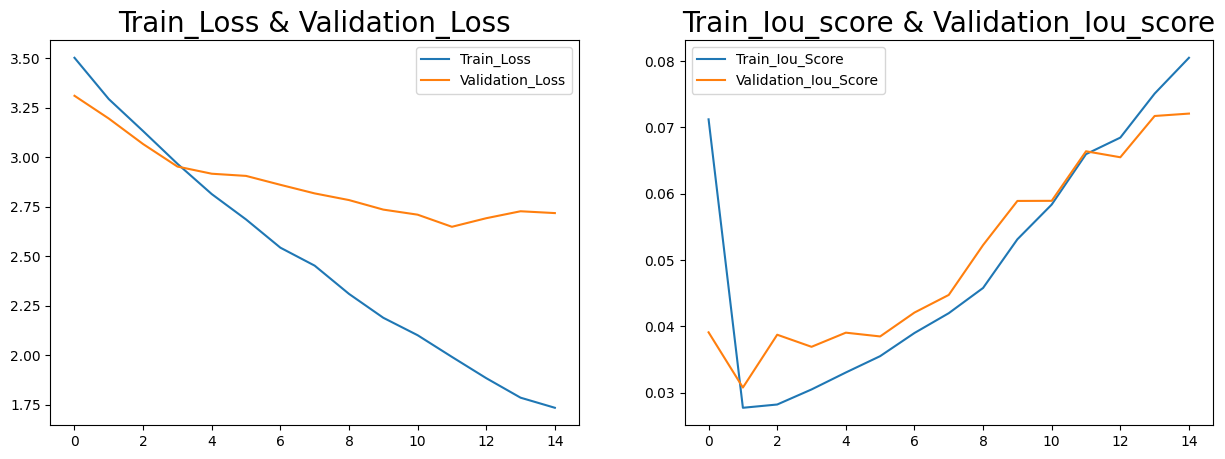

In [76]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(logs['train_loss'],label='Train_Loss')
plt.plot(logs['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(logs['train_iou_score'],label='Train_Iou_Score')
plt.plot(logs['val_iou_score'],label='Validation_Iou_Score')
plt.title('Train_Iou_score & Validation_Iou_score',fontsize=20)
plt.legend()

In [77]:
import torchvision.transforms.functional as TF

class PadToDivisibleBy32:
    def __call__(self, image):
        w, h = image.size
        new_h = (h + 31) // 32 * 32
        new_w = (w + 31) // 32 * 32
        return TF.pad(image, (0, 0, new_w - w, new_h - h))


image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    PadToDivisibleBy32(),
    transforms.ToTensor()
])


mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


In [78]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch

class TestDataset(Dataset):
    def __init__(self, image_dir, annotation_file, transform_image=None, transform_mask=None):
        self.image_dir = image_dir
        self.coco = COCO(annotation_file)
        self.image_ids = list(self.coco.imgs.keys())
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.coco.imgs[image_id]
        image_path = os.path.join(self.image_dir, image_info['file_name'])

        image = Image.open(image_path).convert("RGB")


        mask = np.zeros((image_info['height'], image_info['width']), dtype=np.uint8)


        annotations = self.coco.loadAnns(self.coco.getAnnIds(imgIds=image_id))
        for ann in annotations:
            if 'segmentation' in ann:
                binary_mask = self.coco.annToMask(ann)
                category_id = ann['category_id']
                mask[binary_mask > 0] = category_id


        mask = Image.fromarray(mask)


        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)


        img_view = np.array(image)
        mask_view = np.array(mask)


        if mask_view.max() > 0:
            mask_view = (mask_view * 255 / mask_view.max()).astype(np.uint8)

        sample = {'x': image, 'y': mask, 'img_view': img_view, 'mask_view': mask_view}

        return sample


test_dataset = TestDataset(val_images_dir, val_annotations_file, transform_image=image_transform, transform_mask=mask_transform)

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!


<ipython-input-79-3127e7e5c6d1>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/checkpoints/best.pth"))


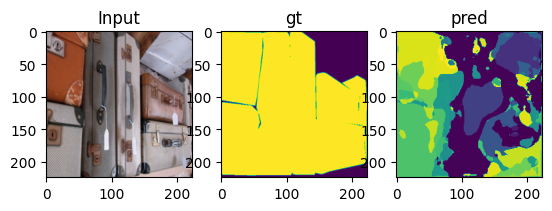

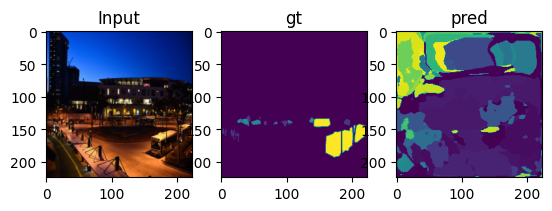

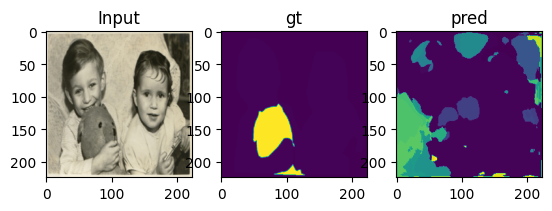

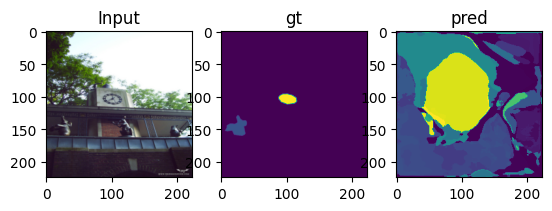

In [79]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("/content/checkpoints/best.pth"))
model.to(device)
show_imgs = 4
random_list = np.random.choice(len(test_dataset), show_imgs, replace=False)

for i in range(show_imgs):
    idx = random_list[i]
    sample = test_dataset[idx]

    pred = model(sample['x'].to('cuda', dtype=torch.float32).unsqueeze(0))

    pred = torch.argmax(pred,dim=1).squeeze(0)

    pred = pred.data.cpu().numpy()

    pred_view = Image.fromarray(np.uint8(pred), 'L')

    img_view = sample['x'].permute(1, 2, 0).cpu().numpy()

    mask_view = sample['mask_view'].squeeze()

    f, axarr = plt.subplots(1, 3)
    axarr[0].imshow(img_view)
    axarr[0].set_title('Input')
    axarr[1].imshow(mask_view)
    axarr[1].set_title('gt')
    axarr[2].imshow(pred_view)
    axarr[2].set_title('pred')

    plt.show()